# **Dataset Story:**

This dataset provides comprehensive information about used cars, making it an excellent resource for a variety of analytical and predictive tasks. One of the primary applications of this data is in price prediction, where it can be used to exemplify the use of linear regression in Machine Learning. By analyzing factors such as make, model, year, mileage, and condition, we can develop models that predict the market value of a used car. Additionally, this dataset can be used for other purposes like trend analysis, feature importance studies, and developing recommendation systems. It offers a rich foundation for both educational and practical applications in data science and machine learning.

### **Business Problem:**

Utilize the existing dataset of used cars to build a machine learning model that predicts the selling prices of these vehicles. The model should use various features of the cars (such as make, model, year, mileage, condition, etc.) to determine the likely market value of each car.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import LocalOutlierFactor


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SyntaxWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [3]:
df = pd.read_csv('/kaggle/input/vehicle-dataset-from-cardekho/Car details v3.csv')

### **Data Preprocessing:**

This code snippet cleans and processes RPM and torque values from this dataset. Initially, it extracts RPM values from the 'torque' column and fills missing values from other columns containing RPM information. Similarly, it extracts torque values from the same column and fills missing values from other columns with torque information. Subsequently, the extracted RPM and torque values are converted to numerical format. Additionally, it extracts brand information from vehicle names and removes unnecessary columns. These operations aim to rectify inconsistencies and missing data in the dataset, preparing it for analysis and modeling

In [4]:
df['RPM'] = df['torque'].str.extract(r'(\d+)rpm', expand=False)
df['RPM'].fillna(df['torque'].str.extract(r'(\d{1,3}(?:,\d{3})*)\(kgm@ rpm\)', expand=False), inplace=True)
df['RPM'].fillna(df['torque'].str.extract(r'(\d+) RPM', expand=False), inplace=True)
df['RPM'].fillna(df['torque'].str.extract(r'(\d+)  rpm ', expand=False), inplace=True)
df['RPM'].fillna(df['torque'].str.extract(r'(\d+) rpm', expand=False), inplace=True)

df['TORQUE'] = df['torque'].str.extract(r'(\d+)Nm@', expand=False)
df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)nm@', expand=False), inplace=True)
df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+) Nm', expand=False), inplace=True)
df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)@', expand=False), inplace=True)
df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)Nm', expand=False), inplace=True)
df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)  Nm', expand=False), inplace=True)
df['TORQUE'].fillna(df['torque'].str.extract(r'(\d+)NM@', expand=False), inplace=True)
df['TORQUE'].fillna(
    (df['torque'].str.extract(r'(\d{1,2}(?:[,.]\d{1,2})?)@\s*\d{1,3}(?:,\d{3})*\(kgm@ rpm\)', expand=False)).astype(
        float) * 9.8, inplace=True)
df['TORQUE'].fillna((df['torque'].str.extract(r'(\d{1,2}(?:[,.]\d{1,2})?)\s*kgm', expand=False)).astype(float) * 9.8,
                    inplace=True)

df['RPM'] = df['RPM'].str.replace(',', '').astype(float)
df['TORQUE'] = df['TORQUE'].astype(float)

df['BRAND'] = df['name'].astype('str').apply(lambda x: x.split()[0])

df['MILEAGE'] = (df['mileage'].apply(lambda x: str(x).replace(' kmpl', '').replace(' km/kg', ''))).astype(float)

df['ENGINE'] = (df['engine'].apply(lambda x: str(x).replace(' CC', ''))).astype(float)

df['MAX_POWER'] = df['max_power'].astype(str).apply(lambda x: x.split()[0])

df.drop(df[df['MAX_POWER'] == 'bhp'].index, inplace=True, axis=0)

df['MAX_POWER'] = df['MAX_POWER'].astype(float)

df.drop(['torque', 'name', 'mileage', 'engine', 'max_power'], axis=1, inplace=True)

### **EDA:**

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

##################### Shape #####################
(8127, 14)
##################### Types #####################
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
seats            float64
RPM              float64
TORQUE           float64
BRAND             object
MILEAGE          float64
ENGINE           float64
MAX_POWER        float64
dtype: object
##################### Head #####################
   year  selling_price  km_driven    fuel seller_type transmission         owner  seats      RPM  TORQUE    BRAND  MILEAGE   ENGINE  MAX_POWER
0  2014         450000     145500  Diesel  Individual       Manual   First Owner  5.000 2000.000 190.000   Maruti   23.400 1248.000     74.000
1  2014         370000     120000  Diesel  Individual       Manual  Second Owner  5.000 2500.000 250.000    Skoda   21.140 1498.000    103.520
2  2006         158000     140000  Petrol  Indi

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    binary_cols = [col for col in dataframe.columns if
                   dataframe[col].dtype not in [int, float] and dataframe[col].nunique() == 2]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    print(f'binary_cols: {len(binary_cols)}')

    return cat_cols, num_cols, cat_but_car, binary_cols

result = grab_col_names(df)
cat_cols, num_cols = result[0], result[1]

Observations: 8127
Variables: 14
cat_cols: 5
num_cols: 8
cat_but_car: 1
num_but_cat: 1
binary_cols: 1


In [7]:
def cat_summary(dataframe, col_name):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

for col in cat_cols:
    cat_summary(df, col)

        fuel  Ratio
fuel               
Diesel  4402 54.165
Petrol  3631 44.678
CNG       56  0.689
LPG       38  0.468
##########################################
                  seller_type  Ratio
seller_type                         
Individual               6765 83.241
Dealer                   1126 13.855
Trustmark Dealer          236  2.904
##########################################
              transmission  Ratio
transmission                     
Manual                7077 87.080
Automatic             1050 12.920
##########################################
                      owner  Ratio
owner                             
First Owner            5289 65.079
Second Owner           2104 25.889
Third Owner             555  6.829
Fourth & Above Owner    174  2.141
Test Drive Car            5  0.062
##########################################
        seats  Ratio
seats               
5.000    6254 76.953
7.000    1120 13.781
8.000     235  2.892
4.000     133  1.637
9.000      80  0

<Axes: >

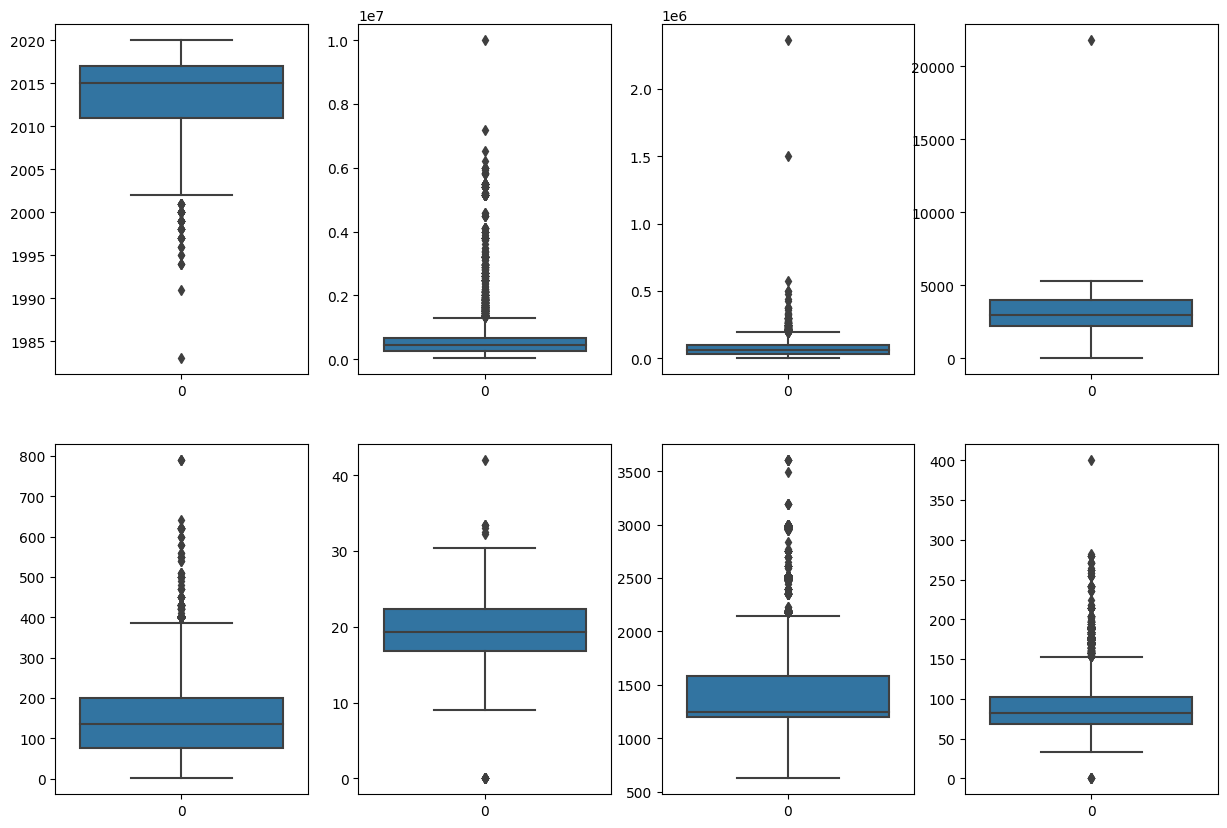

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
sns.boxplot(data=df['year'], ax=ax[0][0])
sns.boxplot(data=df['selling_price'], ax=ax[0][1])
sns.boxplot(data=df['km_driven'], ax=ax[0][2])
sns.boxplot(data=df['RPM'], ax=ax[0][3])
sns.boxplot(data=df['TORQUE'], ax=ax[1][0])
sns.boxplot(data=df['MILEAGE'], ax=ax[1][1])
sns.boxplot(data=df['ENGINE'], ax=ax[1][2])
sns.boxplot(data=df['MAX_POWER'], ax=ax[1][3])


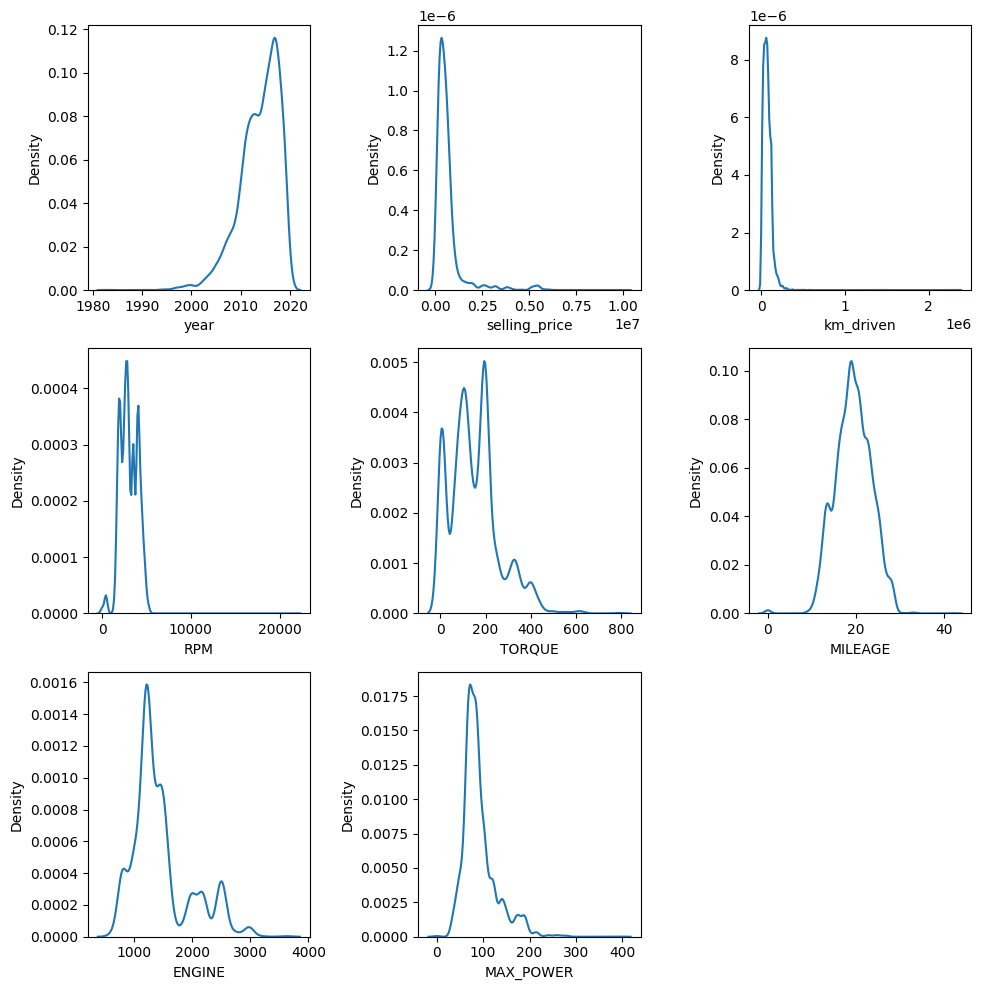

In [9]:
def plot_numerical_col(dataframe, num_cols, plot_type='hist'):
    num_cols_count = len(num_cols)
    num_rows = num_cols_count // 3
    num_rows += 1 if num_cols_count % 3 != 0 else 0  # Eğer sütun sayısı 3'e tam bölünmüyorsa bir ek satır oluştur.

    col_groups = [num_cols[i:i + 12] for i in range(0, num_cols_count, 12)]

    for group in col_groups:
        fig, axes = plt.subplots(num_rows, 3, figsize=(10, 10))
        axes = axes.flatten()

        for i, col in enumerate(group):
            if plot_type == 'hist':
                sns.histplot(data=dataframe[col], ax=axes[i])
            elif plot_type == 'kde':
                sns.kdeplot(data=dataframe[col], ax=axes[i])
            elif plot_type == 'box':
                sns.boxplot(data=dataframe[col], ax=axes[i])
            else:
                print("Geçersiz grafik türü. Lütfen 'hist', 'kde', veya 'box' olarak belirtin.")
                return
            axes[i].set_xlabel(col)

        for j in range(len(group), num_rows * 3):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
plot_numerical_col(df, num_cols,plot_type='kde')

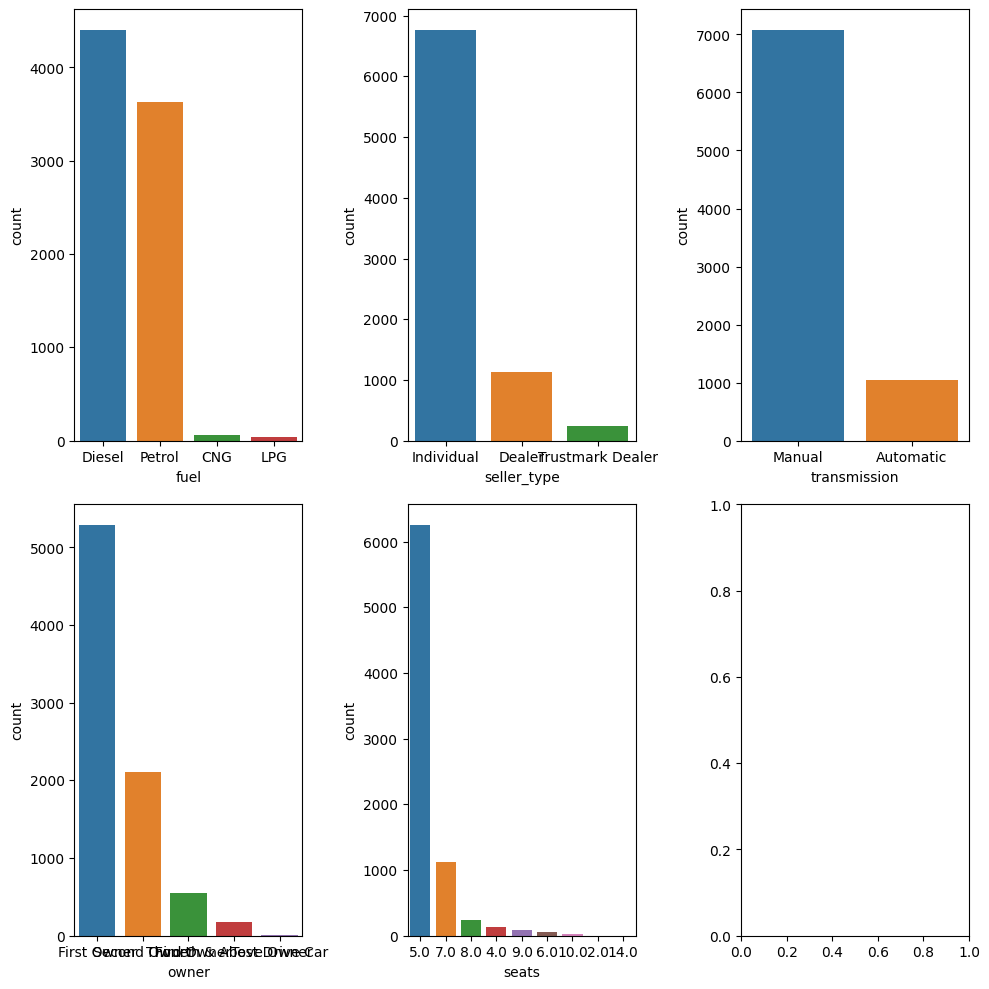

In [10]:
def plot_categoric_col(dataframe, cat_cols):
    cat_cols_count = len(cat_cols)
    cat_rows = cat_cols_count // 3
    cat_rows += 1 if cat_cols_count % 3 != 0 else 0  # Eğer sütun sayısı 3'e tam bölünmüyorsa bir ek satır oluştur.

    fig, axes = plt.subplots(cat_rows, 3, figsize=(10, 10), squeeze=True)
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        sns.countplot(data=dataframe, x=col, ax=axes[i], order=dataframe[col].value_counts().index)
        axes[i].set_xlabel(col)

    plt.tight_layout()
    plt.show()
    
plot_categoric_col(df, cat_cols)

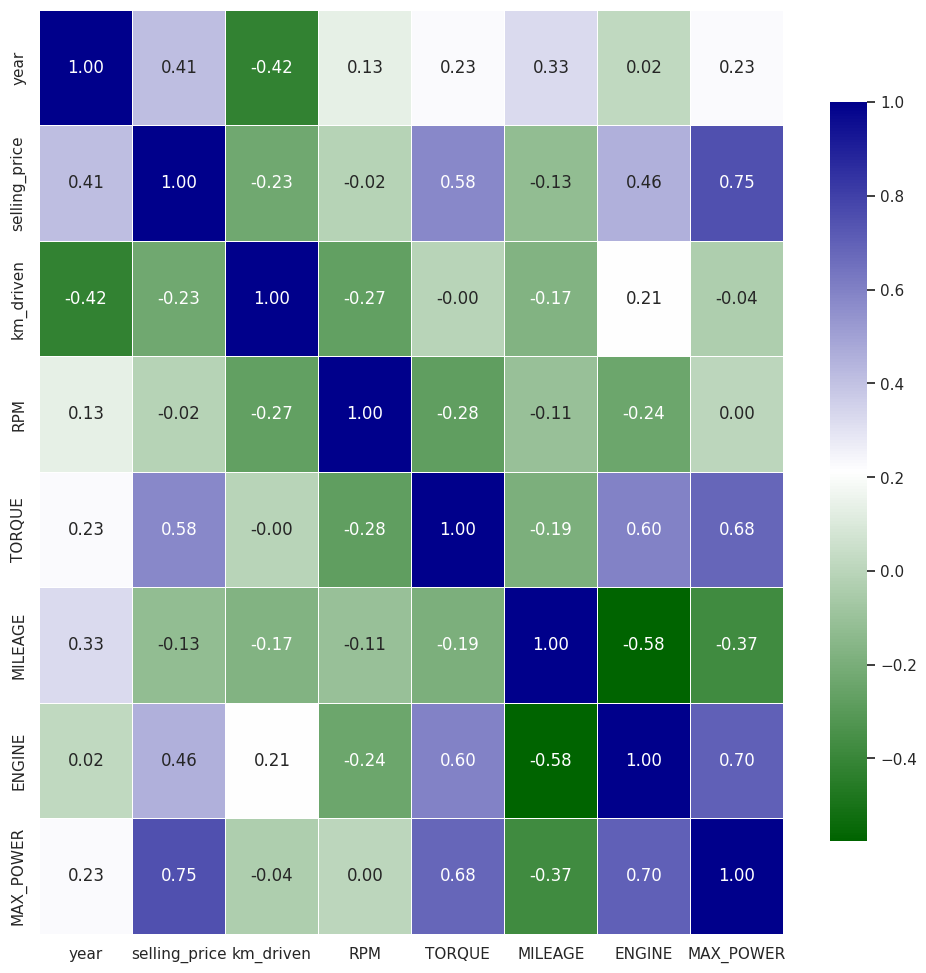

[]

In [11]:
def high_correlated_cols(dataframe, num_cols, plot=False, corr_th=0.90):
    corr = dataframe[num_cols].corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        sns.set(rc={'figure.figsize': (12, 12)})
        colors = [(0, "darkgreen"), (0.5, "white"), (1, "darkblue")]
        cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
        sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .8})
        plt.show()

    return drop_list

high_correlated_cols(df,num_cols,plot=True)

In [12]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
        
rare_analyser(df, 'selling_price', cat_cols)

fuel : 4
        COUNT  RATIO  TARGET_MEAN
fuel                             
CNG        56  0.007   304964.232
Diesel   4402  0.542   791452.922
LPG        38  0.005   200421.053
Petrol   3631  0.447   462441.062


seller_type : 3
                  COUNT  RATIO  TARGET_MEAN
seller_type                                
Dealer             1126  0.139  1443493.745
Individual         6765  0.832   498623.104
Trustmark Dealer    236  0.029   801838.983


transmission : 2
              COUNT  RATIO  TARGET_MEAN
transmission                           
Automatic      1050  0.129  1870827.604
Manual         7077  0.871   455478.913


owner : 5
                      COUNT  RATIO  TARGET_MEAN
owner                                          
First Owner            5289  0.651   783086.414
Fourth & Above Owner    174  0.021   225813.172
Second Owner           2104  0.259   393113.216
Test Drive Car            5  0.001  4403800.000
Third Owner             555  0.068   284015.332


seats : 9
        CO

In [13]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
    
missing_values_table(df)

           n_miss  ratio
RPM           274  3.370
TORQUE        242  2.980
seats         221  2.720
MILEAGE       221  2.720
ENGINE        221  2.720
MAX_POWER     215  2.650


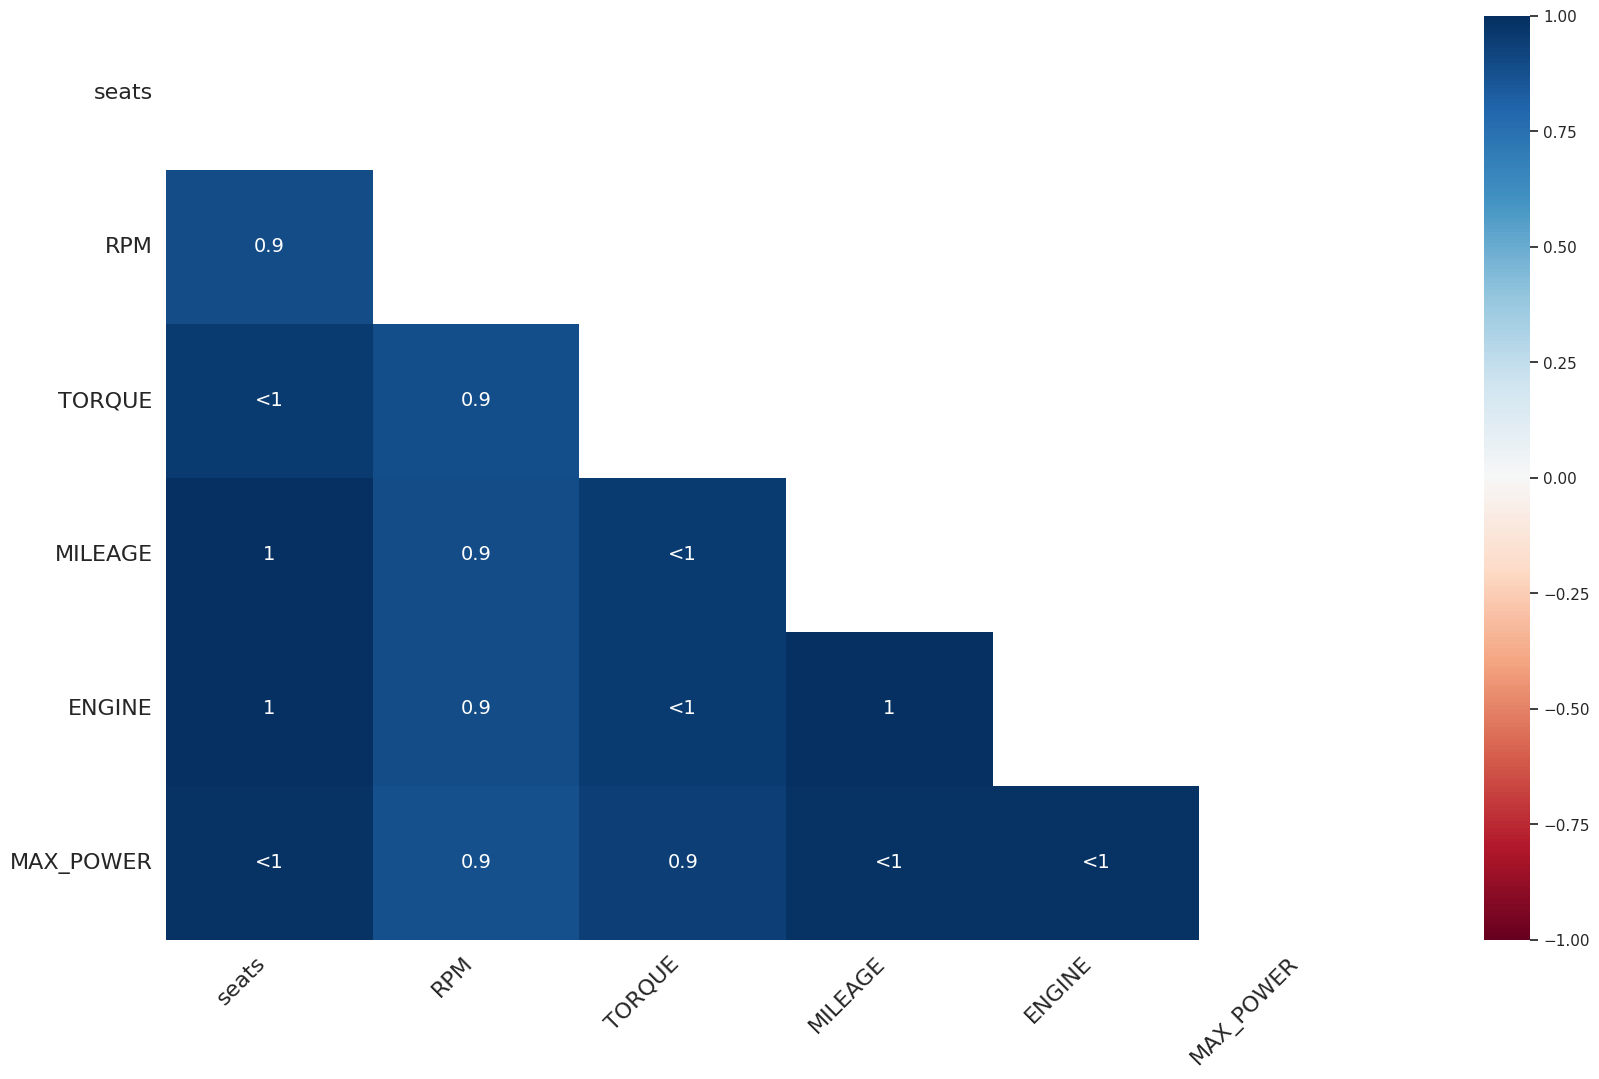

In [14]:
def missing_values_heatmap_grap(df):
    msno.heatmap(df)
    plt.show()
missing_values_heatmap_grap(df)

### **Feature Extraction & Missing Values**

In [15]:
bins = [29999, 100000, 300000, 500000, 1000000, np.inf]
labels = ['<100K', '100K-300K', '300K-500K', '500K-1M', '1M>']
df['PRICE_CAT'] = pd.cut(df['selling_price'], bins=bins, labels=labels, include_lowest=True)

miss_list = ['RPM', 'TORQUE', 'MILEAGE', 'ENGINE', 'MAX_POWER']

for col in miss_list:
    df[col] = df[col].apply(lambda x: np.nan if x == 0 else x)
    df[col].fillna(df.groupby(['BRAND', 'year', 'fuel', 'transmission', 'PRICE_CAT'])[col].transform('mean'),
                   inplace=True)

df['seats'].fillna(df.groupby(['BRAND', 'year', 'fuel', 'transmission', 'PRICE_CAT'])['seats'].transform('median'),
                   inplace=True)

df.dropna(inplace=True)

In [16]:
df['ENGINE_POWER_RATIO'] = df['ENGINE'] / df['MAX_POWER']
df['FUEL_EFF_POWER'] = df['MILEAGE'] / df['MAX_POWER']
df['Power_per_Liter'] = df['MAX_POWER'] / df['ENGINE']
df['Fuel_Efficiency_to_Power'] = df['MILEAGE'] / df['MAX_POWER']
df['Power_per_RPM'] = df['MAX_POWER'] / df['RPM']

result = grab_col_names(df, cat_th=15)
cat_cols, num_cols = result[0], result[1]

Observations: 8045
Variables: 20
cat_cols: 6
num_cols: 13
cat_but_car: 1
num_but_cat: 2
binary_cols: 1


### **Rare Analysis & Encoding:**

In [17]:
rare_analyser(df, target='selling_price', cat_cols=cat_cols)
df.drop(df[df['owner'] == 'Test Drive Car'].index, inplace=True)

df['seats'] = df['seats'].astype(str)

fuel : 4
        COUNT  RATIO  TARGET_MEAN
fuel                             
CNG        53  0.007   315113.151
Diesel   4345  0.540   772767.724
LPG        36  0.004   208083.333
Petrol   3611  0.449   464312.521


seller_type : 3
                  COUNT  RATIO  TARGET_MEAN
seller_type                                
Dealer             1124  0.140  1445483.948
Individual         6685  0.831   485346.644
Trustmark Dealer    236  0.029   801838.983


transmission : 2
              COUNT  RATIO  TARGET_MEAN
transmission                           
Automatic      1012  0.126  1821856.704
Manual         7033  0.874   457099.571


owner : 5
                      COUNT  RATIO  TARGET_MEAN
owner                                          
First Owner            5245  0.652   766410.876
Fourth & Above Owner    170  0.021   227744.071
Second Owner           2079  0.258   395135.268
Test Drive Car            5  0.001  4403800.000
Third Owner             546  0.068   286544.888


seats : 10
        C

In [18]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

df[['owner', 'fuel', 'seats']] = rare_encoder(df[['owner', 'fuel', 'seats']], 0.07)

### **Outlier with LOF:**

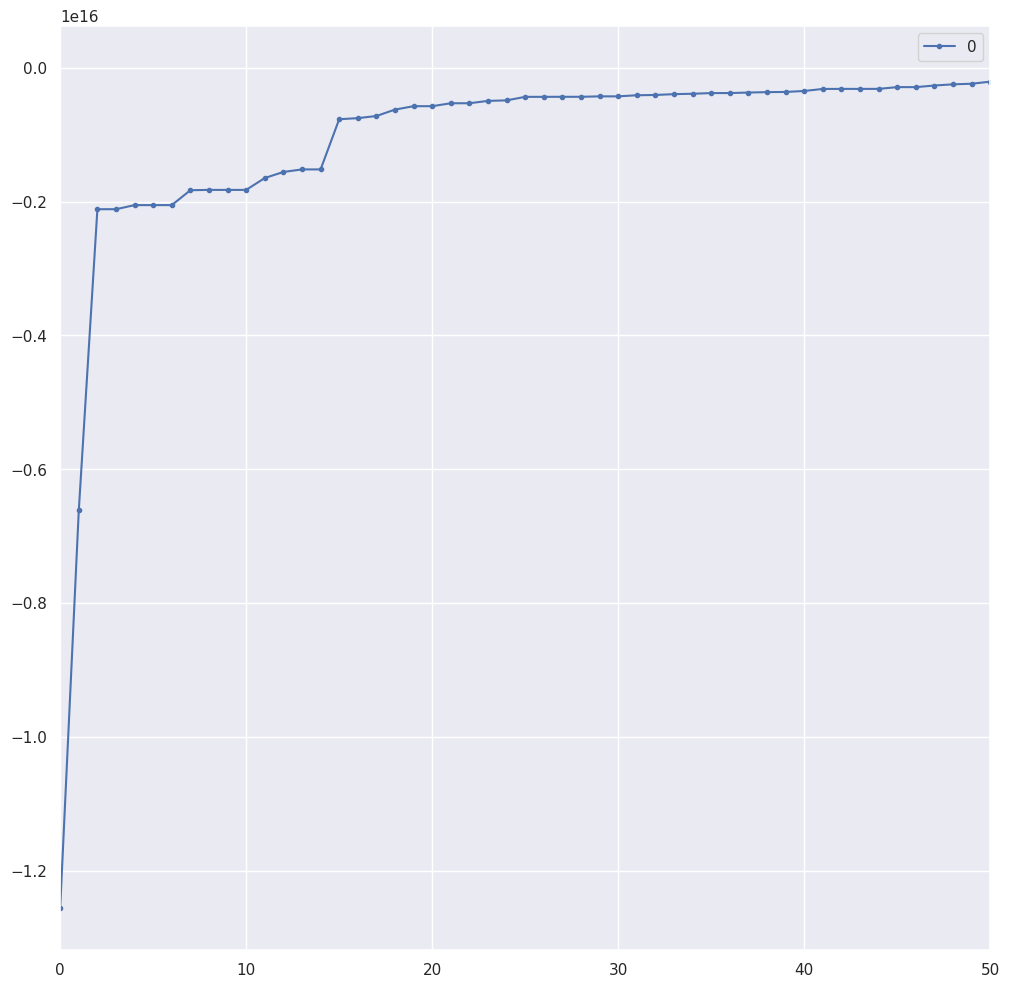

In [19]:
def lof(dataframe, neighbors=20, plot=False):
    dataframe = dataframe.select_dtypes(include=['float64', 'int64'])
    clf = LocalOutlierFactor(n_neighbors=neighbors)
    clf.fit_predict(dataframe)
    df_scores = clf.negative_outlier_factor_
    if plot:
        scores = pd.DataFrame(np.sort(df_scores))
        scores.plot(stacked=True, xlim=[0, 50], style='.-')
        plt.show()

    return df_scores

def lof_indexes(df, threshold):
    df_scores = lof(df)
    th = np.sort(df_scores)[threshold]
    return df[df_scores < th].index

lof(df, plot=True)

lof_indexes = lof_indexes(df, 4)

df.drop(lof_indexes, inplace=True)
df.reset_index(inplace=True, drop=True)

In [20]:
df.drop('PRICE_CAT', axis=1, inplace=True)
result = grab_col_names(df, cat_th=15)
cat_cols, num_cols = result[0], result[1]

df['selling_price'] = df['selling_price'] * 0.0111

Observations: 8036
Variables: 19
cat_cols: 5
num_cols: 13
cat_but_car: 1
num_but_cat: 0
binary_cols: 1


### **Encoding:**

In [21]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype=int)
    return dataframe
df = one_hot_encoder(df, cat_cols + ['BRAND'], drop_first=True)

### **Model:**

In [22]:
y = df["selling_price"]
X = df.drop(["selling_price"], axis=1)


def base_models(X, y):
    print("Base Models....")
    classifiers = [('LR', LinearRegression()),
                   ('KNN', KNeighborsRegressor()),
                   ('CART', DecisionTreeRegressor()),
                   ('RF', RandomForestRegressor()),
                   ('GBM', GradientBoostingRegressor()),
                   ("XGBoost", XGBRegressor(objective='reg:squarederror')),
                   ("LightGBM", LGBMRegressor()),
                   ("CatBoost", CatBoostRegressor(verbose=False))]
    score = pd.DataFrame(index=['rmse', 'r2_score'])
    for name, classifier in classifiers:
        rmse = np.mean(np.sqrt(-cross_val_score(classifier, X, y, cv=3, scoring="neg_mean_squared_error")))
        r2 = np.mean(cross_val_score(classifier, X, y, cv=3, scoring="r2"))
        score[name] = [rmse, r2]
        print(f'{name} hesaplandı...')
    print(score.T)
    
base_models(X,y)

Base Models....
LR hesaplandı...
KNN hesaplandı...
CART hesaplandı...
RF hesaplandı...
GBM hesaplandı...
XGBoost hesaplandı...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2323
[LightGBM] [Info] Number of data points in the train set: 5357, number of used features: 42
[LightGBM] [Info] Start training from score 6947.796500
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 5357, number of used features: 40
[LightGBM] [Info]

### **Model Validation Curve:**

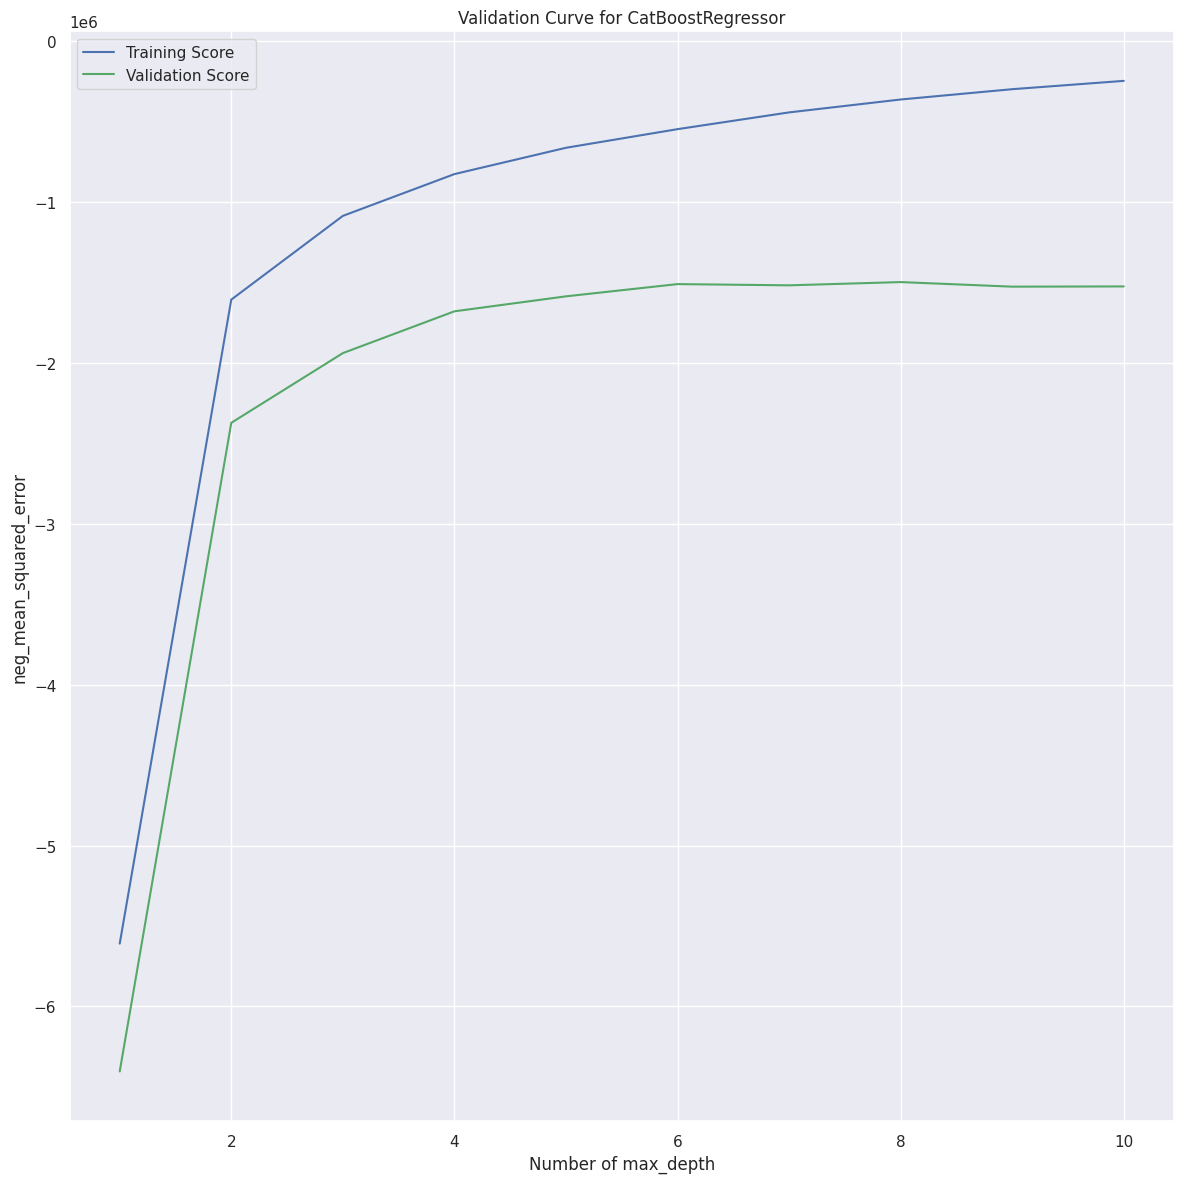

In [23]:
rf_model = CatBoostRegressor(random_state=42,verbose=False).fit(X, y)

def val_curve_params(model, X, y, param_name, param_range, scoring="roc_auc", cv=3):
    train_score, test_score = validation_curve(
        model, X=X, y=y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)

    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)

    plt.plot(param_range, mean_train_score,
             label="Training Score", color='b')

    plt.plot(param_range, mean_test_score,
             label="Validation Score", color='g')

    plt.title(f"Validation Curve for {type(model).__name__}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show(block=True)

val_curve_params(rf_model, X, y, "max_depth", range(1, 11), scoring="neg_mean_squared_error")

### **Final Model:**

In [24]:
rf_model = CatBoostRegressor(random_state=42, max_depth=2, learning_rate=0.1, verbose=False).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(rf_model, X, y, cv=3, scoring="neg_mean_squared_error")))
r2 = np.mean(cross_val_score(rf_model, X, y, cv=3, scoring="r2"))

print(f'RMSE: {rmse}, R2: {r2}')

RMSE: 1435.5986790460554, R2: 0.9701583406808215


### **Feature Importance:**

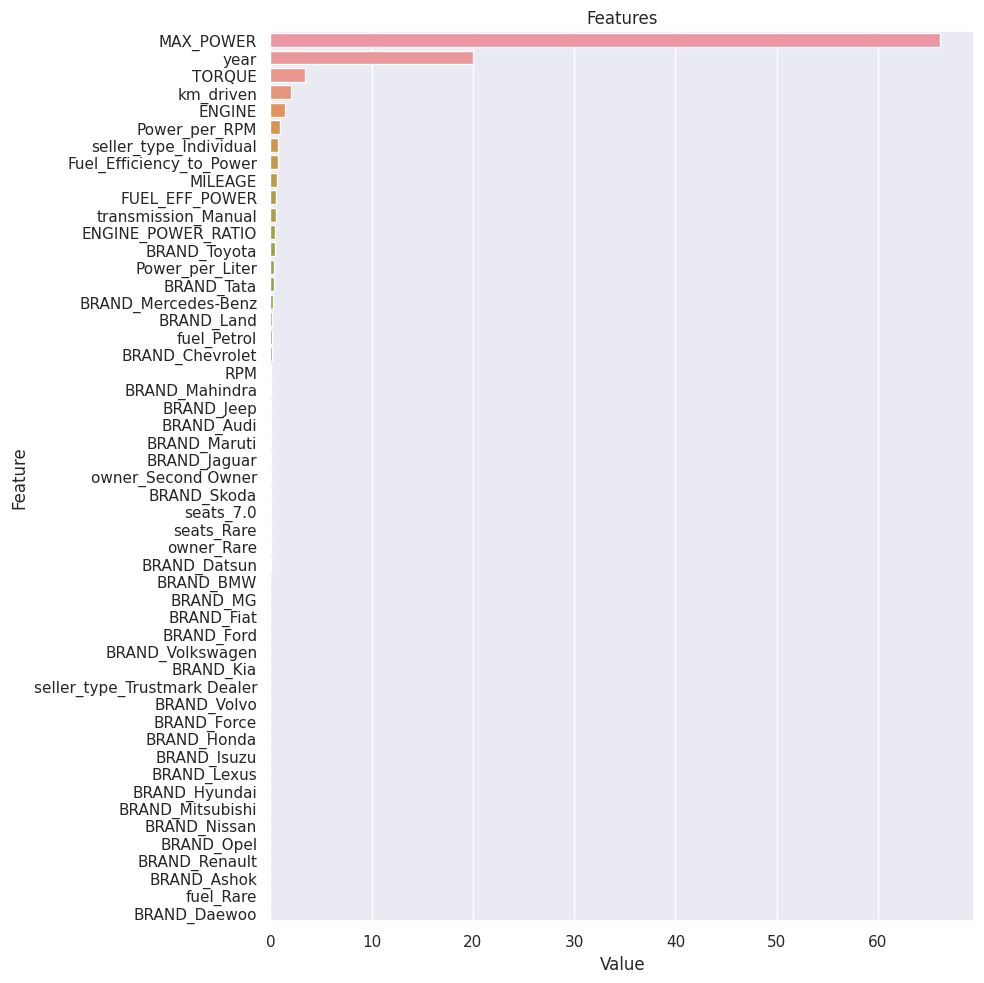

In [25]:
def plot_importance(model, X, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': X.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:len(X)])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)